In [1]:
import numpy as np; import pandas as pd
import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn
#use numba's just-in-time compiler to speed things up
from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; import matplotlib.pyplot as plt; 
#reset matplotlib stle/parameters
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
font_legend = 15; font_axes=15
# %matplotlib inline
from joblib import  Memory

import copy; import sys; import os
from IPython.display import Image, display
from importlib import import_module

In [2]:
FONTSIZE=18
font = {'family': 'serif', 'weight':'normal', 'size':FONTSIZE}
mp.rc('font', **font)
mp.rc('text',usetex=True)

In [3]:
def debug(func):
    """Print the function signature and return value"""
    import functools

    @functools.wraps(func)
    def wrapper_debug(*args, **kwargs):
        args_repr = [repr(a) for a in args]
        kwargs_repr = [f"{k}={v!r}" for k, v in kwargs.items()]
        signature = ", ".join(args_repr + kwargs_repr)
        print(f"Calling {func.__name__}({signature})")
        values = func(*args, **kwargs)
        print(f"{func.__name__!r} returned {values!r}")
        return values

    return wrapper_debug

def theta_hat_func(n,m, MLE):
       #n,m are integer arrays
    if MLE==True:
        theta_hat = n-m
    else:
        # non-MLE
        # theta_hat = n-m
        # theta_hat = (theta_hat) * (theta_hat > 0)
        theta_hat = np.where(n>m, n-m, 0)
         
    return theta_hat


def L_prof_global(n,m, MLE):
    #n,m integer arrays
    # nu_hat = m, if theta_hat = theta_hat_MLE
    # nu_hat  =  (m+n)/2 if theta_hat = n-m
    # nu_hat = 0  if theta_hat != n-m
    theta_hat=theta_hat_func(n,m,MLE)
    # print('n-m ',  n-m)
    if MLE==True:
        # i.e. if theta_hat = n-m
        # assert theta_hat==n-m
        nu_hat = m
    else:
        nu_hat = np.where(theta_hat ==0, (m+n)/2, m)
        # if theta_hat==0:
        #     nu_hat =(m+n)/2
        # else:
        #     _hat = m
        # # if theta_hat== n-m:
        # #     nu_hat = (m+n)/2
        # # else:
        # #     nu_hat = 0
        # # nu_hat = np.where(theta_hat==n-m,
        # #                   (m+n)/2, 
        # #                   0)
    p1=st.poisson.pmf(n, theta_hat+nu_hat)
    p2 = st.poisson.pmf(m, nu_hat)
    return p1*p2

def L_theta_nu(n,m,theta,nu):
    p1 = st.poisson.pmf(n, theta+nu)
    p2 = st.poisson.pmf(m, nu)
    return p1*p2
def lambda_test_2d(n,m, theta, nu, MLE):
    Ln= L_theta_nu(n,m,theta,nu)
    
    Ld= L_prof_global(n,m, MLE)
    eps=1e-20
    Ld=Ld+eps
    lambda_  = -2*np.log(Ln/Ld)
    return np.array(lambda_)

In [176]:
thetaMin, thetaMax =  0, 20
numin, numax = 0, 20
Nmin, Nmax =  1,10
Mmin, Mmax =  1 , 10

def generate_training_data_LR(Bprime, MLE, save_data, sig_or_bkg):
    """Generate the training data, that is, features=[theta, nu, N, M], targets=Z"""
    #sample theta and nu from uniform(0,20)
    theta = st.uniform.rvs(thetaMin, thetaMax, size=Bprime)
    # nu = st.uniform.rvs(nuMin, nuMax, size=Bprime)
    nu= st.uniform.rvs(numin, numax, size=Bprime)
    #n,m ~ F_{\theta,\nu}, ie our simulator. sample n from a Poisson with mean theta+nu 
    n = st.poisson.rvs(theta+ nu, size=Bprime)
    #sample m from a poisson with mean nu
    m = st.poisson.rvs(nu, size=Bprime)
    #sample our observed counts (N,M), which take the place of D
    
    theta_O = st.uniform.rvs(thetaMin, thetaMax, size=Bprime)
    # nu = st.uniform.rvs(nuMin, nuMax, size=Bprime)
    nu_O= st.uniform.rvs(numin, numax, size=Bprime)
    
    N = st.poisson.rvs(theta_O+ nu_O, size=Bprime)
    M = st.poisson.rvs(nu_O, size=Bprime)
    
    if sig_or_bkg=='sig':
        
        lambda_ = lambda_test_2d(n, m, theta, nu, MLE)
        target = np.ones_like(lambda_)
        df = pd.DataFrame({'theta':theta, 'nu': nu, 'lambda': lambda_, 'target': target})
        
    elif sig_or_bkg=='bkg':
        
        lambda_ = lambda_test_2d(N, M, theta_O, nu_O, MLE)
        target = np.zeros_like(lambda_)
        df = pd.DataFrame({'theta':theta, 'nu': nu, 'lambda': lambda_, 'target': target})
        
    return df

In [177]:
df_sig = generate_training_data_LR(Bprime=100000, MLE=False, save_data=False, sig_or_bkg='sig')
df_sig.head()

,theta,nu,lambda,target
0,0.991823,7.866949,0.004477,1.0
1,17.553237,16.450391,0.503511,1.0
2,18.428888,2.485914,1.933862,1.0
3,15.518586,10.640593,0.738783,1.0
4,3.848949,14.770042,0.148607,1.0


In [178]:
df_bkg = generate_training_data_LR(Bprime=100000, MLE=False, save_data=False, sig_or_bkg='bkg')
df_bkg.head()

,theta,nu,lambda,target
0,18.922836,11.624329,0.871327,0.0
1,0.514048,2.974509,0.850546,0.0
2,0.364677,7.712140,0.072733,0.0
3,0.376020,3.958072,2.563019,0.0
4,5.521943,4.807600,5.587317,0.0


## Note that $\lambda$ distribution looks smooth because it's over all $\theta$

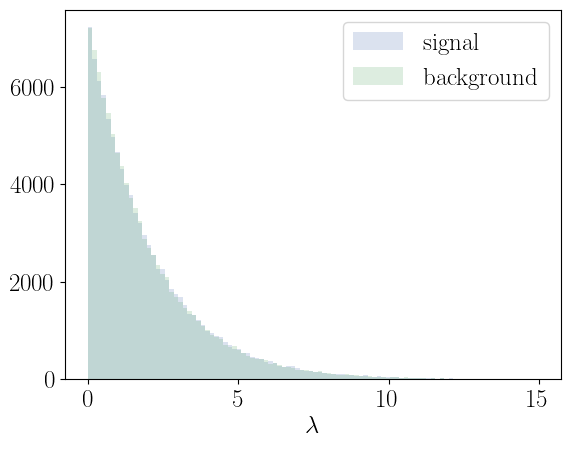

In [213]:
plt.hist(df_sig['lambda'], label='signal',alpha=0.2, range=(0,15), bins=100)
plt.hist(df_bkg['lambda'], label='background',alpha=0.2,range=(0,15),bins=100)
plt.xlabel('$\lambda$')
plt.legend();plt.show()

In [183]:
df_train = pd.concat([df_sig, df_bkg])
df_train

,theta,nu,lambda,target
0,0.991823,7.866949,0.004477,1.0
1,17.553237,16.450391,0.503511,1.0
2,18.428888,2.485914,1.933862,1.0
3,15.518586,10.640593,0.738783,1.0
4,3.848949,14.770042,0.148607,1.0
...,...,...,...,...
99995,1.687766,14.440746,0.246170,0.0
99996,18.215306,7.369372,5.095340,0.0
99997,17.500933,0.436567,2.136865,0.0
99998,16.686499,17.470170,4.378726,0.0


In [184]:
df_train.sample(frac=1)

,theta,nu,lambda,target
70869,17.000057,7.665552,0.446099,1.0
37311,2.535791,3.808729,1.982458,0.0
55735,13.223618,10.353130,1.836652,1.0
98432,0.934153,2.393948,1.359203,0.0
87151,0.334119,3.089969,0.747550,1.0
...,...,...,...,...
1994,10.209048,11.825211,2.309944,1.0
42916,4.696587,6.065527,3.576147,0.0
72514,19.954664,8.529999,0.599237,0.0
77543,9.529418,19.387557,6.879117,1.0


In [185]:
def split_t_x(df, target, source):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = np.array(df[target])
    x = np.array(df[source])
    return t, x

In [186]:
def get_features_training_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return (batch_x, batch_t)

In [187]:
def getwholedata_LRT():
    """ Get train test split arrays"""
    
    data = df_train
        
    train_data, test_data = train_test_split(data, test_size=0.2)
    #split the train data (0.8 of whole set) again into 0.8*0.8=0.64 of whole set
    

    train_data = train_data.reset_index(drop=True)
    test_data  = test_data.reset_index(drop=True)

    target='target'
    # source = ['theta','nu','theta_hat','N','M']

    source = ['theta', 'nu', 'lambda']

    train_t, train_x = split_t_x(train_data, target=target, source=source)
    test_t,  test_x  = split_t_x(test_data,  target=target, source=source)
    print('train_t shape = ', train_t.shape, '\n')
    print('train_x shape = ', train_x.shape, '\n')
    
    # if valid:
        #if you want to also make a validation data set
    train_data, valid_data = train_test_split(train_data, test_size=0.2)
    valid_data = valid_data.reset_index(drop=True)
    valid_t, valid_x = split_t_x(valid_data, target=target, source=source)

        
    return train_t, train_x, test_t,  test_x, valid_t, valid_x

In [188]:
train_t, train_x, test_t,  test_x, valid_t, valid_x = getwholedata_LRT()

train_t shape =  (160000,) 

train_x shape =  (160000, 3) 



In [189]:
class SiLURegressionModel(nn.Module):
    #inherit from the super class
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layers.append(nn.Linear(nfeatures, hidden_size))
                #batch normalization
                layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                # layers.append(nn.Dropout(dropout))
                #ReLU activation 
                layers.append(nn.SiLU())
            else:
                #if this is not the first layer (we dont have layers)
                layers.append(nn.Linear(hidden_size, hidden_size))
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                # layers.append(nn.Dropout(dropout))
                layers.append(nn.SiLU())
                #output layer:
        layers.append(nn.Linear(hidden_size, ntargets)) 

        # ONLY IF ITS A CLASSIFICATION, ADD SIGMOID
        layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.model(x)

In [190]:
@debug
def load_untrained_model(PARAMS):
    """Load an untrained model (with weights initiatted) according to model paramateters in the 
    PARAMS dictionary

    Args:
        PARAMS (dict): dictionary of model/training parameters: i.e. hyperparameters and training parameters.

    Returns:
        utils.RegularizedRegressionModel object
    """
    model = SiLURegressionModel(
        nfeatures=PARAMS['NFEATURES'],
        ntargets=1,
        nlayers=PARAMS["n_layers"],
        hidden_size=PARAMS["hidden_size"],
        dropout=PARAMS["dropout"],
        # activation=PARAMS["activation"]
    )
    # model.apply(initialize_weights)
    print('INITIATED UNTRAINED MODEL:',
          # model
         )
    # print(model)
    return model
    

In [191]:
def load_model(model, PARAMS, pth_string):
    models_path = os.path.join(os.getcwd(), '../models')
    PATH=os.path.join(models_path, pth_string)
    model = SiLURegressionModel(
        nfeatures=PARAMS['NFEATURES'],
        ntargets=1,
        nlayers=PARAMS["n_layers"],
        hidden_size=PARAMS["hidden_size"],
        dropout=PARAMS["dropout"]
    )
    checkpoint = torch.load(PATH)
    print('INITIATED MODEL:',  model)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f'loading model with th string : {pth_string}\n')    
    print(model)
    
    return model

In [192]:
def average_quadratic_loss(f, t, x):
    # f and t must be of the same shape

    # inv = torch.where(t !=0, 1/torch.abs(t), 1)
    return  torch.mean((f - t)**2)

def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x)
def train(model, optimizer, avloss,
          batch_size, 
          n_iterations, traces, 
          step, window, MLE, with_lambda_D):
    
    # to keep track of average losses
    xx, yy_t, yy_v, yy_v_avg = traces
    

    
    if MLE==True:
        train_t, train_x, test_t,  test_x, _, _ = getwholedata_LRT()
    else:
        train_t, train_x, test_t,  test_x, _, _ = getwholedata_LRT()
        
    n = len(test_x)
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    # training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets = get_data_sets(simulate_data=False, batchsize=batch_size)
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.

        
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        
        #Harrison-like Loader
        batch_x, batch_t = get_features_training_batch(train_x, train_t, batch_size)
        
        #Or Ali's Loader
        # batch_x, batch_t = next(training_set_features()), next(training_set_targets())
        # batch_x_eval, batch_t_eval = next(evaluation_set_features()), next(evaluation_set_targets())

        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()      


        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t, x)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            
            #using Harrison-like loader
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, test_x[:n], test_t[:n])
            
            #using Ali's loader
            # acc_t = validate(model, avloss, batch_x, batch_t) 
            # acc_v = validate(model, avloss, batch_x_eval, batch_t_eval)
            

            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
            # compute running average for validation data
            len_yy_v = len(yy_v)
            if   len_yy_v < window:
                yy_v_avg.append( yy_v[-1] )
            elif len_yy_v == window:
                yy_v_avg.append( sum(yy_v) / window )
            else:
                acc_v_avg  = yy_v_avg[-1] * window
                acc_v_avg += yy_v[-1] - yy_v[-window-1]
                yy_v_avg.append(acc_v_avg / window)
                        
            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], yy_t[-1], yy_v[-1]))
            else:
                xx.append(xx[-1] + step)
                    
                print("\r%10d\t%10.6f\t%10.6f\t%10.6f" % \
                          (xx[-1], yy_t[-1], yy_v[-1], yy_v_avg[-1]), 
                      end='')
            
    print()      
    return (xx, yy_t, yy_v, yy_v_avg)

In [193]:
PARAMS_LRT_nonMLE_SILU = {
"n_layers": int(12),
"hidden_size": int(6),
"dropout": float(0.13),
"NFEATURES":int(3),
"activation": "SiLU",
'optimizer_name':'NAdam',
    # 'optimizer_name':'RMSprop',
'starting_learning_rate':float(0.0006),
'momentum':float(0.9),
'batch_size':int(256),
'n_iterations': int(1e4),
'traces_step':int(100),
'L2':float(0.1),
'MLE':False,
'with_lambda_D':True,
'pth_string':'FEB_20_model_lambda_D_nonMLE_SILU.pth'
}

In [194]:
untrained_LRT_model_nonMLE = load_untrained_model(PARAMS_LRT_nonMLE_SILU)

BATCHSIZE=PARAMS_LRT_nonMLE_SILU["batch_size"]
traces_SiLU = ([], [], [], [])
traces_step = 2000
optimizer_name=PARAMS_LRT_nonMLE_SILU["optimizer_name"]

optimizer_SiLU = getattr(torch.optim, str(optimizer_name))(untrained_LRT_model_nonMLE.parameters(), 
                                                           lr=PARAMS_LRT_nonMLE_SILU["starting_learning_rate"])

traces_SiLU = train(model=untrained_LRT_model_nonMLE, 
              optimizer=optimizer_SiLU, 
              avloss=average_quadratic_loss,
              batch_size=BATCHSIZE, 
              n_iterations=PARAMS_LRT_nonMLE_SILU["n_iterations"], 
              traces=traces_SiLU, 
              step=traces_step, 
              window=200,
                MLE=False,
                with_lambda_D=True)



Calling load_untrained_model({'n_layers': 12, 'hidden_size': 6, 'dropout': 0.13, 'NFEATURES': 3, 'activation': 'SiLU', 'optimizer_name': 'NAdam', 'starting_learning_rate': 0.0006, 'momentum': 0.9, 'batch_size': 256, 'n_iterations': 10000, 'traces_step': 100, 'L2': 0.1, 'MLE': False, 'with_lambda_D': True, 'pth_string': 'FEB_20_model_lambda_D_nonMLE_SILU.pth'})
INITIATED UNTRAINED MODEL:
'load_untrained_model' returned SiLURegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=6, bias=True)
    (1): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Linear(in_features=6, out_features=6, bias=True)
    (4): SiLU()
    (5): Linear(in_features=6, out_features=6, bias=True)
    (6): SiLU()
    (7): Linear(in_features=6, out_features=6, bias=True)
    (8): SiLU()
    (9): Linear(in_features=6, out_features=6, bias=True)
    (10): SiLU()
    (11): Linear(in_features=6, out_features=6, bias=True)
    (12): SiLU()

10.562323581720001

In [250]:
def generate_X(theta, nu, N_points, MLE):
    
    N = st.poisson.rvs(theta+nu, size=N_points)
    M = st.poisson.rvs(nu, size=N_points)
    lambda_D = lambda_test_2d(N, M, theta, nu, MLE)#.flatten()
    X_sig = np.empty((N_points, 3))
    X_sig[:,0] = np.ones_like(theta)*theta
    X_sig[:,1] = np.ones_like(nu)*nu
    X_sig[:,2]  = lambda_D
    sig_X = torch.Tensor(X_sig)
    
    theta_0 =np.random.uniform(0,20)
    nu_0 = np.random.uniform(0,20)
    N_0 = st.poisson.rvs(theta_0+nu_0, size=N_points)
    M_0 = st.poisson.rvs(nu_0, size=N_points)
    g=[]
    lambda_0 = lambda_test_2d(N_0, M_0, theta_0, nu_0, MLE)#.flatten()
    g.append(lambda_0)
    N_1 = st.poisson.rvs(theta_0+nu_0, size=N_points)
    M_1 = st.poisson.rvs(nu_0, size=N_points)
    lambda_1 = lambda_test_2d(N_1, M_1, theta_0, nu_0, MLE)
    g.append(lambda_1)
    
    
    X_bkg = np.empty((N_points, 3))
    X_bkg[:,0] = np.ones_like(theta_0)*theta_0
    X_bkg[:,1] = np.ones_like(nu_0)*nu_0
    X_bkg[:,2]  = lambda_0
    bkg_X = torch.Tensor(X_bkg)
    
    eval_array = np.vstack((sig_X, bkg_X))
    
    
    return np.array(g).flatten(), torch.Tensor(eval_array)

In [247]:
thetaMin, thetaMax =  0, 20
numin, numax = 0, 20
Nmin, Nmax =  1,10
Mmin, Mmax =  1 , 10

def make_eval_tensor(Bprime, MLE):
    #sample theta and nu from uniform(0,20)
    g_l = []
    sig_df = generate_training_data_LR(Bprime=Bprime, MLE=False, save_data=False, sig_or_bkg='sig')
    bkg_df = generate_training_data_LR(Bprime=Bprime, MLE=False, save_data=False, sig_or_bkg='bkg')
    g_l.append(bkg_df['lambda'])
    bkg_df_2 = generate_training_data_LR(Bprime=Bprime, MLE=False, save_data=False, sig_or_bkg='bkg')
    g_l.append(bkg_df_2['lambda'])
    g = np.array(g_l).flatten()
    
    df = pd.concat([sig_df, bkg_df])
    df.sample(frac=1)
    df_np = df[['theta','nu', 'lambda']].to_numpy()
    return df, g, torch.Tensor(df_np)

In [251]:
df, g, eval_tensor = make_eval_tensor(Bprime=1000, MLE=False)

In [259]:
g, eval_tensor=generate_X(theta=19, nu=5, N_points=1000, MLE=False)
eval_tensor.shape

torch.Size([2000, 3])

In [260]:
g.shape

(2000,)

In [261]:
D = untrained_LRT_model_nonMLE(eval_tensor).view(-1).detach().numpy()

In [262]:
D.shape

(2000,)

In [263]:
g.shape

(2000,)

In [264]:
f = g * D/(1-D)
f.shape

(2000,)

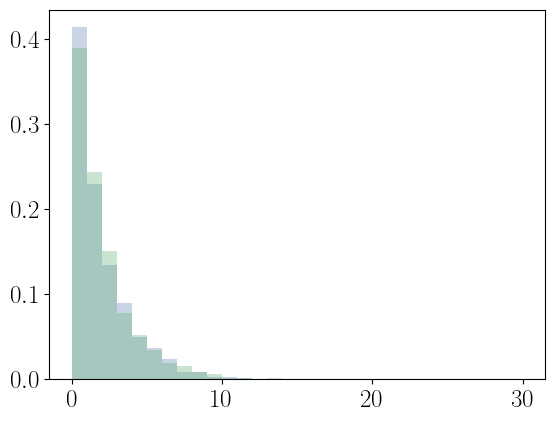

In [265]:
plt.hist(df['lambda'], alpha=0.3, bins=30, range=(0,30),density=True);
plt.hist(f,alpha=0.3, bins=30, range=(0,30),density=True)

plt.show()
